In [1]:
import numpy as np
import pickle as pkl
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pyspark.mllib.clustering import KMeans
from collections import Counter
from nltk.corpus import stopwords
import string
import pyspark as ps    # for the pyspark suite
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType
import unicodedata
import nltk

from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams
from nltk import pos_tag
from nltk import RegexpParser

from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF

import sys
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover, NGram, \
        CountVectorizer, IDF, Word2Vec
from pyspark.sql.functions import udf, col, explode, collect_list, to_date, concat
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, \
        FloatType, ArrayType, BooleanType
from nltk.stem import SnowballStemmer

import pyspark as ps    # for the pyspark suite







In [2]:
df_full = spark.read.csv('s3a://usfocus/congress_full.csv', header = True, sep = ',', inferSchema=True)

In [17]:
df_full.show()

+--------------------+-------+----------+--------------------+--------+
|             content|subject|     dates|                name|congress|
+--------------------+-------+----------+--------------------+--------+
|  HR 5961 IH 101s...| Health|12/03/1990|H.R.5961 — 101st ...|   101.0|
|  HR 5908 IH 101s...| Health|11/19/1990|H.R.5908 — 101st ...|   101.0|
|  HR 5899 IH 101s...| Health|12/03/1990|H.R.5899 — 101st ...|   101.0|
|  HR 5898 IH 101s...| Health|12/10/1990|H.R.5898 — 101st ...|   101.0|
|  HR 5897 IH 101s...| Health|12/03/1990|H.R.5897 — 101st ...|   101.0|
|  HR 5890 IH 101s...| Health|12/03/1990|H.R.5890 — 101st ...|   101.0|
|  HR 5888 IH 101s...| Health|11/19/1990|H.R.5888 — 101st ...|   101.0|
|  HR 5851 IH 101s...| Health|11/19/1990|H.R.5851 — 101st ...|   101.0|
|  HR 5845 IH 101s...| Health|10/30/1990|H.R.5845 — 101st ...|   101.0|
|  HR 5830 IH 101s...| Health|10/30/1990|H.R.5830 — 101st ...|   101.0|
|  HR 5807 IH 101s...| Health|10/30/1990|H.R.5807 — 101st ...|  

In [3]:
#df_clean.printSchema()

sub_list =['Health',
 'Government+Operations+and+Politics',
 'Taxation',
 'Armed+Forces+and+National+Security',
 'Public+Lands+and+Natural+Resources',
 'International+Affairs',
 'Congress',
 'Crime+and+Law+Enforcement',
 'Immigration',
 'Science,+Technology,+Communications',
 'Education',
 'Finance+and+Financial+Sector',
 'Environmental+Protection',
 'Labor+and+Employment',
 'Transportation+and+Public+Works',
 'Energy',
 'Civil+Rights+and+Liberties,+Minority+Issues',
 'Emergency+Management',
 'Law',
 'Economics+and+Public+Finance',
 'Commerce',
 'Native+Americans',
 'Housing+and+Community+Development',
 'Social+Welfare',
 'Water+Resources+Development',
 'Agriculture+and+Food',
 'Animals',
 'Foreign+Trade+and+International+Finance',
 'Families',
 'Sports+and+Recreation',
 'Arts,+Culture,+Religion',
 'Social+Sciences+and+History']

sub_dict = {}
for i in range(len(sub_list)):
    sub_dict[sub_list[i]] = i

sub_dict

#df_clean.count()

#df_clean.write.format('com.databricks.spark.csv').options(header='true').save('s3a://usfocus/congress_full.csv')





#df_clean_pd = df_full.sample(False, 0.6, 42)

#df_full_pd = df_full.toPandas()

#df_full_pd.shape

#df_full_pd['label'] = df_full_pd['subject'].map(sub_dict)

#df_full_pd.head()

#df_clean_spark = spark.createDataFrame(df_full_pd)
#df_clean_spark.write.format('com.databricks.spark.csv').options(header='true').save('s3a://usfocus/congress_full_final.csv')

{'Agriculture+and+Food': 25,
 'Animals': 26,
 'Armed+Forces+and+National+Security': 3,
 'Arts,+Culture,+Religion': 30,
 'Civil+Rights+and+Liberties,+Minority+Issues': 16,
 'Commerce': 20,
 'Congress': 6,
 'Crime+and+Law+Enforcement': 7,
 'Economics+and+Public+Finance': 19,
 'Education': 10,
 'Emergency+Management': 17,
 'Energy': 15,
 'Environmental+Protection': 12,
 'Families': 28,
 'Finance+and+Financial+Sector': 11,
 'Foreign+Trade+and+International+Finance': 27,
 'Government+Operations+and+Politics': 1,
 'Health': 0,
 'Housing+and+Community+Development': 22,
 'Immigration': 8,
 'International+Affairs': 5,
 'Labor+and+Employment': 13,
 'Law': 18,
 'Native+Americans': 21,
 'Public+Lands+and+Natural+Resources': 4,
 'Science,+Technology,+Communications': 9,
 'Social+Sciences+and+History': 31,
 'Social+Welfare': 23,
 'Sports+and+Recreation': 29,
 'Taxation': 2,
 'Transportation+and+Public+Works': 14,
 'Water+Resources+Development': 24}

In [4]:
df_full.count()

81124

In [5]:
df_full.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)



In [6]:
tokenizer = RegexTokenizer(inputCol="content", outputCol="tokens", pattern="\\W", minTokenLength=3)

In [7]:
remover = StopWordsRemover(inputCol="tokens", outputCol='tokens_nostopwords')

In [8]:
from pyspark import keyword_only
from pyspark.ml.util import Identifiable
from pyspark.ml.pipeline import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from nltk.stem import SnowballStemmer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

# Custom stemming transformer class for pyspark
class Stemming_Transformer(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(Stemming_Transformer, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None, language='english', ):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)

    def _transform(self, dataset):
        opinion_stemm = SnowballStemmer('english')
        udfStemmer = udf(lambda tokens: [opinion_stemm.stem(word) for word in tokens], ArrayType(StringType()))

        inCol = self.getInputCol()
        outCol = self.getOutputCol()

        return dataset.withColumn(outCol, udfStemmer(inCol))

In [9]:
stemmer = Stemming_Transformer(inputCol='tokens_nostopwords', outputCol='tokens_stemmed')

In [10]:
cv = CountVectorizer(inputCol='tokens_stemmed', outputCol='tokens_countvectorized', minDF=2.0,vocabSize=5000)

In [11]:
idf = IDF(inputCol='tokens_countvectorized', outputCol='token_idf')

In [12]:

pipe_stem = Pipeline(stages=[tokenizer, remover, stemmer])

In [13]:
model_stem = pipe_stem.fit(df_full)

In [14]:
df_stemmed = model_stem.transform(df_full)

In [15]:
cv_model = cv.fit(df_stemmed)

In [16]:
df_countvector = cv_model.transform(df_stemmed)

In [15]:
df_countvector.show()

+--------------------+--------------------+----------+--------------------+--------+--------------------+--------------------+--------------------+----------------------+
|             content|             subject|     dates|                name|congress|              tokens|  tokens_nostopwords|      tokens_stemmed|tokens_countvectorized|
+--------------------+--------------------+----------+--------------------+--------+--------------------+--------------------+--------------------+----------------------+
|[Congressional Bi...|Civil+Rights+and+...|01/25/1995|H.J.Res.16 — 104t...|   104.0|[congressional, b...|[congressional, b...|[congression, bil...|  (5000,[1,2,7,8,10...|
|[Congressional Bi...|Civil+Rights+and+...|01/25/1995|H.J.Res.13 — 104t...|   104.0|[congressional, b...|[congressional, b...|[congression, bil...|  (5000,[0,1,2,7,8,...|
|[Congressional Bi...|Civil+Rights+and+...|03/15/1995|H.J.Res.10 — 104t...|   104.0|[congressional, b...|[congressional, b...|[congression, bil..

In [17]:
Vocab = cv_model.vocabulary

In [18]:
len(Vocab)

5000

In [35]:
#df_tfidf.select('token_idf').show()

In [19]:
model_idf = idf.fit(df_countvector)



df_tfidf = model_idf.transform(df_countvector)

In [20]:
df_tfidf.show()

+--------------------+--------------------+----------+--------------------+--------+--------------------+--------------------+--------------------+----------------------+--------------------+
|             content|             subject|     dates|                name|congress|              tokens|  tokens_nostopwords|      tokens_stemmed|tokens_countvectorized|           token_idf|
+--------------------+--------------------+----------+--------------------+--------+--------------------+--------------------+--------------------+----------------------+--------------------+
|[Congressional Bi...|Civil+Rights+and+...|01/25/1995|H.J.Res.16 — 104t...|   104.0|[congressional, b...|[congressional, b...|[congression, bil...|  (5000,[1,2,7,8,10...|(5000,[1,2,7,8,10...|
|[Congressional Bi...|Civil+Rights+and+...|01/25/1995|H.J.Res.13 — 104t...|   104.0|[congressional, b...|[congressional, b...|[congression, bil...|  (5000,[0,1,2,7,8,...|(5000,[0,1,2,7,8,...|
|[Congressional Bi...|Civil+Rights+and+.

In [37]:
df_presidential = spark.read.json('s3a://usfocus/presidential-full-final.json')

In [38]:
df_presidential.count()

975

In [39]:
df_presidential = df_presidential.filter(df_presidential['content'] != 'null')

In [40]:
df_presidential.count()

974

In [53]:
#df_presidential_pd = df_presidential.toPandas()

In [69]:
#type(df_presidential_pd['content'][0].astype('string'))

In [70]:
#df_presidential_pd['content'] = df_presidential_pd['content'].map(lambda x:x.encode('utf-8'))

In [41]:
df_presidential.show()

+---------------+--------------------+--------------------+------------------+--------------------+--------------------+
|_corrupt_record|                 _id|             content|              date|                link|        speech_title|
+---------------+--------------------+--------------------+------------------+--------------------+--------------------+
|           null|[58d03d7addc55a11...|Thank you.  (Appl...|    March 22, 2016|https://millercen...| Remarks to the P...|
|           null|[58d03d7fddc55a11...|Mr. Speaker, Mr. ...|  January 12, 2016|https://millercen...| 2016 State of th...|
|           null|[58d03d84ddc55a11...|THE PRESIDENT:  G...|     June 26, 2015|https://millercen...| Remarks in Eulog...|
|           null|[58d03d89ddc55a11...|UDIENCE MEMBER:  ...|     March 7, 2015|https://millercen...| Remarks at the 5...|
|           null|[58d03d8eddc55a11...|Mr. Speaker, Mr. ...|  January 20, 2015|https://millercen...| 2015 State of th...|
|           null|[58d03d93ddc55a

In [42]:
model_stem_pre = pipe_stem.fit(df_presidential)

In [43]:
df_pres_stem = model_stem_pre.transform(df_presidential)

In [44]:
df_pres_stem.show()

+---------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|_corrupt_record|                 _id|             content|              date|                link|        speech_title|              tokens|  tokens_nostopwords|      tokens_stemmed|
+---------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|           null|[58d03d7addc55a11...|Thank you.  (Appl...|    March 22, 2016|https://millercen...| Remarks to the P...|[thank, you, appl...|[thank, applause,...|[thank, applaus, ...|
|           null|[58d03d7fddc55a11...|Mr. Speaker, Mr. ...|  January 12, 2016|https://millercen...| 2016 State of th...|[speaker, vice, p...|[speaker, vice, p...|[speaker, vice, p...|
|           null|[58d03d84ddc55a11...|THE PRESIDENT:  G...|     June 26, 2015|ht

In [45]:
Vector_presidential = cv_model.transform(df_pres_stem)

In [46]:
Vector_presidential.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- content: string (nullable = true)
 |-- date: string (nullable = true)
 |-- link: string (nullable = true)
 |-- speech_title: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_countvectorized: vector (nullable = true)



In [47]:
Vector_presidential.show()

+---------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+
|_corrupt_record|                 _id|             content|              date|                link|        speech_title|              tokens|  tokens_nostopwords|      tokens_stemmed|tokens_countvectorized|
+---------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+
|           null|[58d03d7addc55a11...|Thank you.  (Appl...|    March 22, 2016|https://millercen...| Remarks to the P...|[thank, you, appl...|[thank, applause,...|[thank, applaus, ...|  (5000,[2,8,10,11,...|
|           null|[58d03d7fddc55a11...|Mr. Speaker, Mr. ...|  January 12, 2016|https://millercen...| 2016 State of th...|[speaker, vice, p...|[speaker, vice, p...|[speaker, 

In [48]:
df_tfidf_pre = model_idf.transform(Vector_presidential)

In [49]:
df_tfidf_pre.show()

+---------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+
|_corrupt_record|                 _id|             content|              date|                link|        speech_title|              tokens|  tokens_nostopwords|      tokens_stemmed|tokens_countvectorized|           token_idf|
+---------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+
|           null|[58d03d7addc55a11...|Thank you.  (Appl...|    March 22, 2016|https://millercen...| Remarks to the P...|[thank, you, appl...|[thank, applause,...|[thank, applaus, ...|  (5000,[2,8,10,11,...|(5000,[2,8,10,11,...|
|           null|[58d03d7fddc55a11...|Mr. Speaker, Mr. ...|  January 12, 2016|https://mi

In [40]:
#df_tfidf_pre.write.format('com.databricks.spark.csv').options(header='true').save('s3a://usfocus/presidential_tfidf.csv')

In [20]:
topicWord=udf(lambda tkn: sub_dict[tkn],IntegerType())

In [21]:
df_tfidf=df_tfidf.withColumn("label",topicWord(df_tfidf.subject))

In [22]:
df_tfidf.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_countvectorized: vector (nullable = true)
 |-- token_idf: vector (nullable = true)
 |-- label: integer (nullable = true)



In [50]:
df_tfidf.show()

+--------------------+--------------------+----------+--------------------+--------+--------------------+--------------------+--------------------+----------------------+--------------------+-----+
|             content|             subject|     dates|                name|congress|              tokens|  tokens_nostopwords|      tokens_stemmed|tokens_countvectorized|           token_idf|label|
+--------------------+--------------------+----------+--------------------+--------+--------------------+--------------------+--------------------+----------------------+--------------------+-----+
|[Congressional Bi...|Civil+Rights+and+...|01/25/1995|H.J.Res.16 — 104t...|   104.0|[congressional, b...|[congressional, b...|[congression, bil...|  (5000,[1,2,7,8,10...|(5000,[1,2,7,8,10...|   16|
|[Congressional Bi...|Civil+Rights+and+...|01/25/1995|H.J.Res.13 — 104t...|   104.0|[congressional, b...|[congressional, b...|[congression, bil...|  (5000,[0,1,2,7,8,...|(5000,[0,1,2,7,8,...|   16|
|[Congress

In [23]:
from pyspark.ml.classification import NaiveBayes

In [24]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial",featuresCol="token_idf", labelCol="label")

In [25]:
splits = df_tfidf.randomSplit([0.7, 0.3])

In [26]:
df_train = splits[0]
df_test = splits[1]

In [26]:
#df_train.count(), df_test.count(), df_transformed.count()

In [27]:
df_test.persist()

DataFrame[content: string, subject: string, dates: string, name: string, congress: double, tokens: array<string>, tokens_nostopwords: array<string>, tokens_stemmed: array<string>, tokens_countvectorized: vector, token_idf: vector, label: int]

In [28]:
df_train.persist()

DataFrame[content: string, subject: string, dates: string, name: string, congress: double, tokens: array<string>, tokens_nostopwords: array<string>, tokens_stemmed: array<string>, tokens_countvectorized: vector, token_idf: vector, label: int]

In [29]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [30]:
model = nb.fit(df_train)

# apply the model on the test setM
result = model.transform(df_test)

In [53]:
# keep only label and prediction to compute accuracy
predictionAndLabels = result.select("prediction", "label")

In [54]:
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                  metricName="accuracy")

print("Accuracy: {}".format(evaluator.evaluate(predictionAndLabels)))

Accuracy: 0.760466740622


In [67]:
thetaarray = model.theta.toArray().T

In [68]:
thetaarray.shape

(5000, 32)

In [69]:
thetaarray[0]

array([-6.44553536, -6.44159832, -5.87027188, -6.50157639, -7.00347993,
       -7.06424165, -6.86110947, -6.53833564, -6.29573312, -6.89665716,
       -6.65150232, -6.47315729, -6.72018956, -6.29819749, -6.49102978,
       -6.71936598, -6.67217646, -6.73311194, -6.54535073, -6.54100572,
       -6.58992112, -6.84902373, -6.30920488, -6.25168744, -6.98012943,
       -6.67274765, -6.69053388, -6.70332163, -6.45160215, -7.1942937 ,
       -7.04123278, -8.41015784])

In [31]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
result.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_countvectorized: vector (nullable = true)
 |-- token_idf: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [78]:
result.show()

+--------------------+--------------------+-----------+--------------------+--------+--------------------+--------------------+--------------------+----------------------+--------------------+-----+--------------------+--------------------+----------+
|             content|             subject|      dates|                name|congress|              tokens|  tokens_nostopwords|      tokens_stemmed|tokens_countvectorized|           token_idf|label|       rawPrediction|         probability|prediction|
+--------------------+--------------------+-----------+--------------------+--------+--------------------+--------------------+--------------------+----------------------+--------------------+-----+--------------------+--------------------+----------+
|" [Congressional ...|      Social+Welfare| 04/10/1995|H.R.1267 — 104th ...|   104.0|[congressional, b...|[congressional, b...|[congression, bil...|  (5000,[0,1,2,3,4,...|(5000,[0,1,2,3,4,...|   23|[-420480.02574563...|[0.0,0.0,0.0,0.0,...|    

In [45]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.PuRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontweight='bold')
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=8,rotation=90,fontweight='medium')
    plt.yticks(tick_marks, classes,fontsize=8,fontweight='medium')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #    plt.text(j, i, cm[i, j],
    #             horizontalalignment="center",
    #             color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontweight='bold',fontsize=12)
    plt.xlabel('Predicted label',fontweight='bold',fontsize=12)
    plt.figure(figsize=(30,30),dpi=1000)


In [35]:
true_label = result.select('label').collect()

predict_label = result.select('prediction').collect()

In [37]:
len(true_label),len(predict_label)

(24339, 24339)

In [38]:
confusion_matrix_nb = confusion_matrix(np.array(true_label), np.array(predict_label))

In [39]:
confusion_matrix_nb

array([[1652,   10,    7, ...,    4,    3,   34],
       [  28,  883,   11, ...,    3,   36,   90],
       [  58,   30, 1888, ...,    9,    1,    4],
       ..., 
       [   0,    0,    0, ...,   37,    1,    8],
       [   0,    0,    0, ...,    1,   64,   26],
       [   1,    0,    0, ...,    0,    1,   25]])

In [40]:
subject_ordered = sorted(sub_dict,key=sub_dict.get)

In [41]:
label_list=range(0,32)

Normalized confusion matrix
[[  7.97682279e-01   4.82858522e-03   3.38000966e-03 ...,   1.93143409e-03
    1.44857557e-03   1.64171898e-02]
 [  1.57657658e-02   4.97184685e-01   6.19369369e-03 ...,   1.68918919e-03
    2.02702703e-02   5.06756757e-02]
 [  2.49677142e-02   1.29143349e-02   8.12742144e-01 ...,   3.87430047e-03
    4.30477830e-04   1.72191132e-03]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   6.60714286e-01
    1.78571429e-02   1.42857143e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   1.01010101e-02
    6.46464646e-01   2.62626263e-01]
 [  3.57142857e-02   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    3.57142857e-02   8.92857143e-01]]


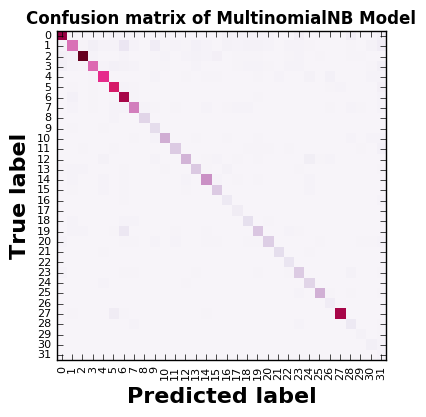

In [47]:
plot_confusion_matrix(confusion_matrix_nb, classes = label_list,normalize = True, title = 'Confusion matrix of MultinomialNB Model')

In [118]:
df_tfidf.write.json('s3a://usfocus/congress_tfidf.json')

In [123]:
result.write.json('s3a://usfocus/result_tfidf.csv')

In [124]:
result_presidential = model.transform(df_tfidf_pre)

In [128]:
result_presidential = result_presidential.select('content','date','link','speech_title','tokens_countvectorized','tokens_stemmed','token_idf','rawPrediction','probability','prediction')

In [136]:
#result_presidential.write.json('s3a://usfocus/result_presidential_tfidf.json')

In [48]:
from pyspark.ml.classification import LogisticRegression

In [49]:
LG = LogisticRegression(featuresCol="token_idf", labelCol="label")

In [50]:
model_lg = LG.fit(df_train)

# apply the model on the test setM
result_lg = model_lg.transform(df_test)

In [51]:
result_lg.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_countvectorized: vector (nullable = true)
 |-- token_idf: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [52]:
# keep only label and prediction to compute accuracy
predictionAndLabels_lg = result_lg.select("prediction", "label")

# compute accuracy on the test set
evaluator_lg = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                  metricName="accuracy")

print("Accuracy: {}".format(evaluator_lg.evaluate(predictionAndLabels_lg)))

Accuracy: 0.853239656518


In [55]:
predict_label_lg = result_lg.select('prediction').collect()

In [56]:
len(true_label),len(predict_label_lg)

(24339, 24339)

In [57]:
confusion_matrix_lg = confusion_matrix(np.array(true_label), np.array(predict_label_lg))

Normalized confusion matrix
[[  9.04876871e-01   7.72573636e-03   7.24287784e-03 ...,   4.82858522e-04
    4.82858522e-04   0.00000000e+00]
 [  5.06756757e-03   7.98423423e-01   1.12612613e-02 ...,   0.00000000e+00
    2.25225225e-03   5.63063063e-04]
 [  8.17907878e-03   1.72191132e-03   9.35858803e-01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  3.57142857e-02   1.78571429e-02   1.78571429e-02 ...,   6.42857143e-01
    1.78571429e-02   0.00000000e+00]
 [  3.03030303e-02   4.04040404e-02   1.01010101e-02 ...,   0.00000000e+00
    7.17171717e-01   2.02020202e-02]
 [  1.07142857e-01   3.57142857e-02   0.00000000e+00 ...,   0.00000000e+00
    2.50000000e-01   3.21428571e-01]]


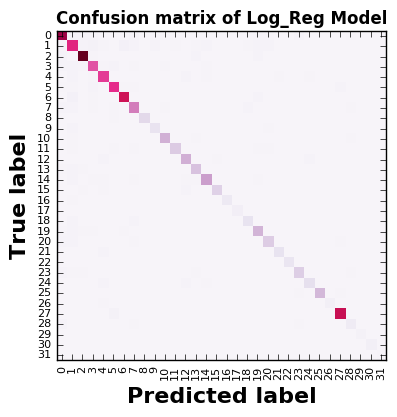

In [58]:
plot_confusion_matrix(confusion_matrix_lg, classes = label_list,normalize = True, title = 'Confusion matrix of Log_Reg Model')

In [59]:
from pyspark.ml.classification import RandomForestClassifier

In [60]:
rf = RandomForestClassifier(featuresCol="token_idf", labelCol="label")

In [61]:
model_rf = rf.fit(df_train)

# apply the model on the test setM
result_rf = model_rf.transform(df_test)

In [62]:
# keep only label and prediction to compute accuracy
predictionAndLabels_rf = result_rf.select("prediction", "label")

# compute accuracy on the test set
evaluator_rf = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                  metricName="accuracy")

print("Accuracy: {}".format(evaluator_rf.evaluate(predictionAndLabels_rf)))

Accuracy: 0.447512223181


In [63]:
predict_label_rf = result_rf.select('prediction').collect()

In [64]:


len(true_label),len(predict_label_rf)

(24339, 24339)

In [65]:
confusion_matrix_rf = confusion_matrix(np.array(true_label), np.array(predict_label_rf))

Normalized confusion matrix
[[ 0.81313375  0.04200869  0.04732014 ...,  0.          0.          0.        ]
 [ 0.08727477  0.4329955   0.26407658 ...,  0.          0.          0.        ]
 [ 0.00860956  0.00258287  0.96254843 ...,  0.          0.          0.        ]
 ..., 
 [ 0.07142857  0.28571429  0.10714286 ...,  0.          0.          0.        ]
 [ 0.1010101   0.33333333  0.06060606 ...,  0.          0.          0.        ]
 [ 0.03571429  0.07142857  0.03571429 ...,  0.          0.          0.        ]]


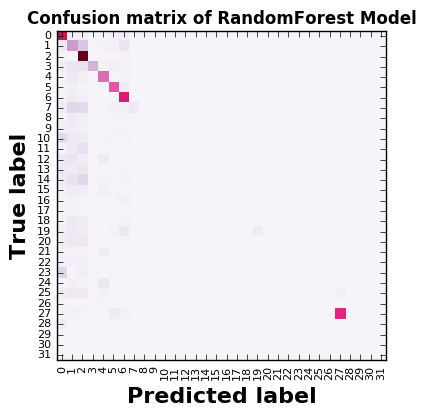

In [66]:
plot_confusion_matrix(confusion_matrix_rf, classes = label_list,normalize = True, title = 'Confusion matrix of RandomForest Model')